In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [76]:
categories = pd.read_csv('../result/category.csv')['category'].values
category = categories[2]

In [77]:
df = pd.read_csv('../result/data_modeling.csv')
df = df[df['category'] == category]
df = df.drop('category', axis=1)

df['date'] = pd.to_datetime(df['date'])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 707 to 1072
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   366 non-null    datetime64[ns]
 1   hits_sum                               366 non-null    int64         
 2   hits_mean                              366 non-null    float64       
 3   visits_sum                             366 non-null    int64         
 4   visits_mean                            366 non-null    float64       
 5   page_views_sum                         366 non-null    int64         
 6   page_views_mean                        366 non-null    float64       
 7   first_visits_sum                       366 non-null    int64         
 8   first_visits_mean                      366 non-null    float64       
 9   time_on_site_sum                       366 non-null    int64  

,date,hits_sum,hits_mean,visits_sum,visits_mean,page_views_sum,page_views_mean,first_visits_sum,first_visits_mean,time_on_site_sum,...,transactions_sum,medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,action_Check out,action_Click through of product lists,action_Completed purchase,action_Product detail views
707,2016-08-01,14606,52.920290,276,1.0,9925,35.960145,154,0.557971,338709,...,38,0,12,10,56,0,0,153,0,123
708,2016-08-02,12551,47.722433,263,1.0,8611,32.741445,105,0.399240,277338,...,8,0,7,2,112,20,0,146,0,117
709,2016-08-03,34638,73.230444,473,1.0,22852,48.312896,219,0.463002,593578,...,0,0,8,0,131,26,0,259,0,214
710,2016-08-04,13521,42.518868,318,1.0,8975,28.223270,184,0.578616,248711,...,2,5,0,4,133,0,0,176,0,142
711,2016-08-05,17803,55.634375,320,1.0,12575,39.296875,187,0.584375,342223,...,82,4,25,0,128,10,0,176,0,144


In [78]:
# Time splitting 
n_days = 90
max_date = df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

train = df[df['date'] <= cutoff]
test = df[df['date'] > cutoff]

test = test.set_index('date')
train = train.set_index('date')

In [79]:
# Preparation
test_target = test[['transactions_sum']]
test_fields = test.drop(['transactions_sum'], axis=1)


train_target = train[['transactions_sum']]
train_fields = train.drop(['transactions_sum'], axis=1)

In [80]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=123)

# model = GridSearchCV(estimator=xgb_reg, 
#                              param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
#                              scoring='neg_mean_absolute_error',
#                              refit=True,
#                              cv=5)

# model.fit(train_fields, train_target)

In [81]:
# print("Best score: ", model.best_score_)
# print("Best params: ", model.best_params_)
# print("Best estimator: \n", model.best_estimator_)

In [82]:
# imp_feat_reg = model\
#                 .best_estimator_\
#                 .get_booster()\
#                 .get_score(importance_type='gain')

# pd.DataFrame.from_dict(imp_feat_reg, orient='index').plot(kind='bar')
# plt.show()

In [83]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(train_fields, train_target.values.reshape(-1, ))

RandomForestRegressor(random_state=42)

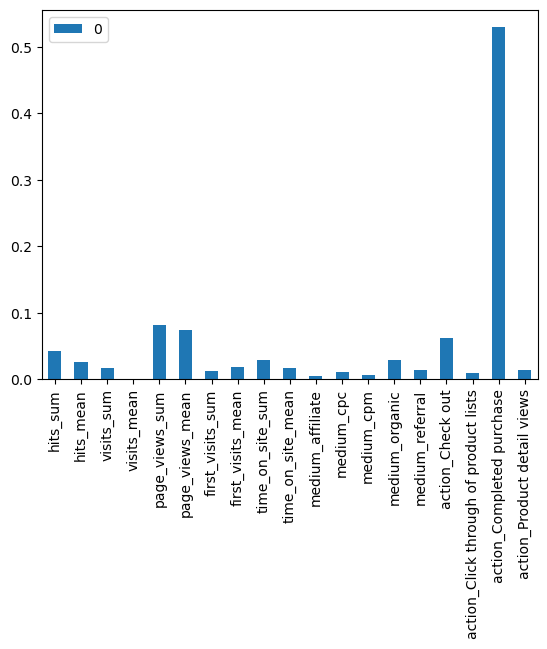

In [84]:
imp_feat_reg = model.feature_importances_

pd.DataFrame(imp_feat_reg.reshape(1, -1), columns=train_fields.columns).T.plot(kind='bar')
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error

predictions_reg = model.predict(test_fields)
predictions_reg = pd.DataFrame(predictions_reg, index=test.index, columns=['transactions_pred'])

# Calculate performance metrics
mse = mean_squared_error(test_target, predictions_reg)
print(f"Mean Squared Error: {mse}")

df_pred = pd.merge(test_target.iloc[:-1], predictions_reg, left_index=True, right_index=True)
df_pred

Mean Squared Error: 251.93446111111115


,transactions_sum,transactions_pred
date,,
2017-05-04,32,23.16
2017-05-05,37,36.20
2017-05-06,11,19.91
2017-05-07,19,10.04
2017-05-08,15,11.52
...,...,...
2017-07-27,65,58.90
2017-07-28,40,42.76
2017-07-29,6,20.85


In [102]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = px.line(df_pred.resample('M').mean(), labels={'value': 'Total Transactions',
                                                    'transcations_sum': 'Transactions (Actual)',
                                                    'pred_transactions': 'Transactions {Prediction}'})
fig.show()

In [103]:
# Prediction next month value
combined_fields = pd.concat([train_fields, test_fields])
predictions_all = model.predict(combined_fields)
predictions_all = pd.DataFrame(predictions_all, index=combined_fields.index, columns=['transactions_pred'])

pred_08 = predictions_all.resample('M').mean().values.mean()
temp_frame = pd.DataFrame(index=pd.date_range(start='2017-08-01', end='2017-08-31'))
temp_frame.index.name = 'date'
temp_frame['transactions_pred'] = pred_08

In [104]:
df_result = pd.concat([df_pred, temp_frame]).reset_index().copy()
df_result['category'] = [category] * df_result.shape[0]
# df_result['transactions_sum'] = df_result['transactions_sum'].astype('int64')
df_result['transactions_pred'] = df_result['transactions_pred'].astype('int64')

df_result.to_csv(f'../result/prediction-revenue-{category}.csv', index=False)